In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as T
import lasagne

/home/mayank/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Using gpu device 0: GeForce GTX 960M (CNMeM is disabled)


In [2]:
import theano

In [3]:
from scipy.stats import norm
%matplotlib inline

In [4]:
mu, sigma = -1,1
xs = np.linspace(-5,5,1000)

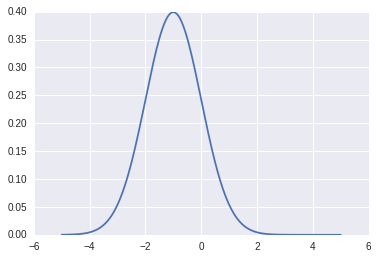

In [5]:
plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma))

In [52]:
train_iters = 500
M = 200

In [7]:
input_var_d = T.col('input_d')
target_var_d = T.col('output_d')
input_var_g = T.col('input_g')
target_var_g = T.col('output_g')


In [123]:
#### Pre-Training

##Discriminator

l_in = lasagne.layers.InputLayer(shape=(M, 1), input_var=input_var_d)
l_fw_1 = lasagne.layers.DenseLayer(l_in, num_units = 6, nonlinearity=lasagne.nonlinearities.tanh,
                                  W = lasagne.init.GlorotUniform(),
                                  b = lasagne.init.Constant(0.0))
l_fw_2 = lasagne.layers.DenseLayer(l_fw_1, num_units = 5, nonlinearity=lasagne.nonlinearities.tanh,
                                  W = lasagne.init.GlorotUniform(),
                                  b = lasagne.init.Constant(0.0))
l_out = lasagne.layers.DenseLayer(l_fw_2, num_units = 1, nonlinearity =lasagne.nonlinearities.tanh,
                                 W = lasagne.init.GlorotUniform(),
                                 b = lasagne.init.Constant(0.0))


In [124]:
prediction = lasagne.layers.get_output(l_out)
loss = lasagne.objectives.squared_error(prediction, target_var_d)
loss = loss.mean()

In [125]:
params = lasagne.layers.get_all_params(l_out, trainable=True)
updates = lasagne.updates.momentum(loss, params, learning_rate = 0.03)

In [126]:
train = theano.function([input_var_d, target_var_d], loss, updates=updates, allow_input_downcast=True)


In [127]:
output = theano.function([input_var_d], prediction, allow_input_downcast=True)

In [128]:
###Plotting the decision surface
def plot_d0():
    f, ax = plt.subplots(1)
    xs = np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')
    
    ###Decision Boundry
    r = 1000 #Resolution
    xs = np.linspace(-5,5,r)
    ds = np.zeros((r,1)) #Decision Surface
    
    ####We process multiple points in parallel in a minibatch
    for i in range(r/M):
        x = np.reshape(xs[M*i:M*(i+1)], (M,1))
        ds[M*i:M*(i+1)] = output(x)
    
    ax.plot(xs, ds, label='decision boundry')
    ax.set_ylim(0,1.1)
    plt.legend()

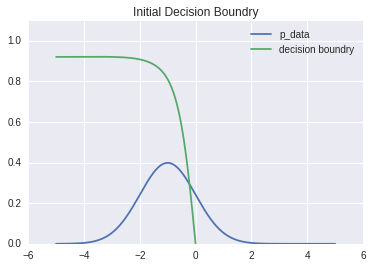

In [129]:
plot_d0()
plt.title('Initial Decision Boundry')

In [130]:
## Pretraining starts

lh = np.zeros(1000)
for i in range(1000):
    d = (np.random.random(M))
    d = np.reshape(d, (M,1))
    labels =norm.pdf(d, loc=mu, scale=sigma)
    labels = np.reshape(labels, (M,1))
    lh[i] = train(d, labels)
    if i%100 == 0:
        print i

0
100
200
300
400
500
600
700
800
900


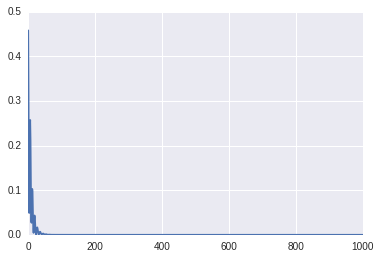

In [131]:
plt.plot(lh)

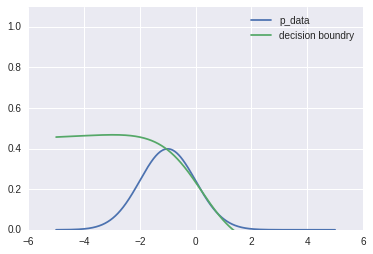

In [132]:
plot_d0()

In [193]:
##### The actual generative adversarial network #######

## Generator
g_in = lasagne.layers.InputLayer(shape=(M,1), input_var=input_var_g)
g_fw_1 = lasagne.layers.DenseLayer(g_in, num_units=6, nonlinearity=lasagne.nonlinearities.tanh,
                                  W = lasagne.init.GlorotUniform(),
                                  b = lasagne.init.Constant(0.0))
g_fw_2 = lasagne.layers.DenseLayer(g_fw_1, num_units=5, nonlinearity=lasagne.nonlinearities.tanh,
                                  W = lasagne.init.GlorotUniform(),
                                  b = lasagne.init.Constant(0.0))
g_out = lasagne.layers.DenseLayer(g_fw_2, num_units=1, nonlinearity=lasagne.nonlinearities.tanh,
                                  W = lasagne.init.GlorotUniform(),
                                  b = lasagne.init.Constant(0.0))

#Generated_sample
prediction_g = lasagne.layers.get_output(g_out)


In [194]:
## Discriminator - D(G(x))
dg_fw_1 = lasagne.layers.DenseLayer(g_out, num_units = 6, nonlinearity=lasagne.nonlinearities.tanh,
                                  W = lasagne.init.GlorotUniform(),
                                  b = lasagne.init.Constant(0.0))
dg_fw_2 = lasagne.layers.DenseLayer(dg_fw_1, num_units = 5, nonlinearity=lasagne.nonlinearities.tanh,
                                  W = lasagne.init.GlorotUniform(),
                                  b = lasagne.init.Constant(0.0))
dg_out = lasagne.layers.DenseLayer(dg_fw_2, num_units = 1, nonlinearity =lasagne.nonlinearities.tanh,
                                 W = lasagne.init.GlorotUniform(),
                                 b = lasagne.init.Constant(0.0))

#Prediction
prediction_dg = lasagne.layers.get_output(dg_out)

In [195]:
## Discriminator - D((x))
#Shares weights with D(G(x))
d_in = lasagne.layers.InputLayer(shape=(M, 1), input_var=input_var_d)
d_fw_1 = lasagne.layers.DenseLayer(d_in, num_units = 6, nonlinearity=lasagne.nonlinearities.tanh,
                                  W = dg_fw_1.W,
                                  b = dg_fw_1.b)
d_fw_2 = lasagne.layers.DenseLayer(d_fw_1, num_units = 5, nonlinearity=lasagne.nonlinearities.tanh,
                                  W = dg_fw_2.W,
                                  b = dg_fw_2.b)
d_out = lasagne.layers.DenseLayer(d_fw_2, num_units = 1, nonlinearity =lasagne.nonlinearities.tanh,
                                 W = dg_out.W,
                                 b = dg_out.b)

#Prediction
prediction_d = lasagne.layers.get_output(d_out)

In [196]:
params_d_g_values = lasagne.layers.get_all_param_values(dg_out)

params_d_values = lasagne.layers.get_all_param_values(d_out)

params_g_values = lasagne.layers.get_all_param_values(g_out)

params_pretrained_d_values = lasagne.layers.get_all_param_values(l_out)


In [197]:
## Using pretrained weights to imporve D

lasagne.layers.set_all_param_values(d_out, params_pretrained_d_values)

In [198]:
## Getting the parameters
params_d_g = lasagne.layers.get_all_params(dg_out)

params_g = lasagne.layers.get_all_params(g_out)

params_d = lasagne.layers.get_all_params(d_out)

In [199]:
## Objectives
obj_d = T.mean(T.log(prediction_d) + T.log(1-prediction_dg))
obj_g = T.mean(T.log(prediction_dg))

## Updates
updates_d = lasagne.updates.momentum(1-obj_d, params_d, learning_rate = 0.01)
updates_g = lasagne.updates.momentum(1-obj_g, params_d_g, learning_rate = 0.01)

In [200]:
## Train functions ##
train_d = theano.function([input_var_g, input_var_d], obj_d, updates=updates_d, allow_input_downcast=True)

train_g = theano.function([input_var_g], obj_g, updates=updates_g, allow_input_downcast=True)

In [201]:
## Output functions##
out_d = theano.function([input_var_d], prediction_d, allow_input_downcast=True)
out_dg = theano.function([input_var_g], prediction_dg, allow_input_downcast=True)
out_g = theano.function([input_var_g], prediction_g, allow_input_downcast=True)

In [202]:
###### MULTIPLY GEN OUT BY 5######




def plot_fig():
    
    f, ax = plt.subplots(1)
    #p_data
    xs = np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')
    
    #decision_boundry
    r=5000
    xs = np.linspace(-5,5,r)
    ds=np.zeros((r,1))
    #process muliple points in parallel
    for i in range(r/M):
        x=np.reshape(xs[M*i:M*(i+1)], (M,1))
        ds[M*i:M*(i+1)]=out_d(x)
        
    ax.plot(xs, ds, label='decision_boundry')
        
   
    
    
    
    # distribution of inverse mapped points
    zs = np.linspace(-5,5,r)
    gs = np.zeros((r,1))
    for i in range(r/M):
        z=np.reshape(zs[M*i:M*(i+1)],(M,1))
        gs[M*i:M*(i+1)]=out_g(z)
    histc, edges = np.histogram(gs, bins=10)
    ax.plot(np.linspace(-5,5,10), histc/float(r), label='p_g')
    
    ax.set_ylim(-2,1.1)
    plt.legend()
    

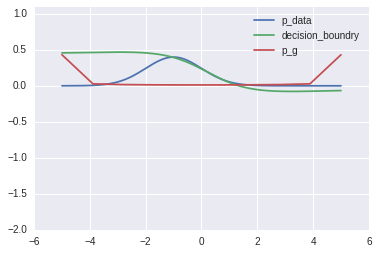

In [203]:
plot_fig()

In [204]:
#Training algo
k=1
histd, histg = np.zeros(train_iters), np.zeros(train_iters)

for i in range(train_iters):
    for j in range(k):
        x = np.random.normal(mu, sigma, M)
        x.sort()
        z = np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01
        histd[i] = train_d(np.reshape(z,(M,1)), np.reshape(x,(M,1)))
        
    z = np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01
    histg[i] = train_g(np.reshape(z,(M,1)))
    if i%(train_iters//10) == 0:
        print(float(i)/float(train_iters))
        

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


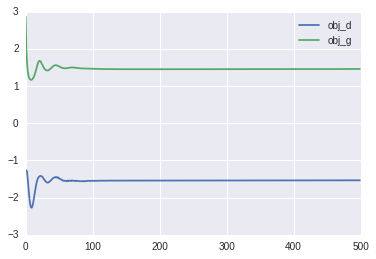

In [205]:
plt.plot(histd, label='obj_d')
plt.plot(1-histg, label='obj_g')
plt.legend()

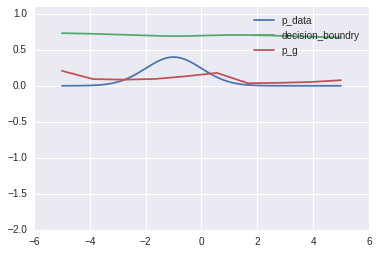

In [206]:
plot_fig()

In [108]:
params_g_values_new = lasagne.layers.get_all_param_values(g_out)
print params_g_values_new

[array([[ 1.30596614,  0.15652905, -0.76615256, -1.50211143,  2.76057363,
        -1.81654203]], dtype=float32), array([ 0.07704598,  0.17704991, -0.10111853, -0.34572825,  0.06170582,
       -0.35312507], dtype=float32), array([[ 0.32851645, -0.42302608, -0.22110763, -0.00642242,  0.1905548 ],
       [-0.43358937, -0.03991547, -0.9145661 ,  0.40119427, -0.05533509],
       [ 0.39163426, -0.78634292,  0.54554439, -0.00740609, -0.58671033],
       [-0.2824246 ,  0.5266037 ,  1.00079584,  0.60969096,  0.30274045],
       [-0.48704275,  0.18148941, -0.15871662,  0.25676173,  0.04781254],
       [-0.2725476 ,  0.23117809,  1.16025686, -0.0436177 ,  0.03793383]], dtype=float32), array([ 0.19358657,  0.32269427, -0.26993176,  0.12281479, -0.4187955 ], dtype=float32), array([[-0.01593558],
       [-0.06563958],
       [-1.64538014],
       [-0.03530419],
       [ 0.04346195]], dtype=float32), array([-1.70299935], dtype=float32)]


In [109]:
params_g_values

[array([[ 1.28034103, -0.15809663, -0.7287339 , -1.40600955,  2.76786065,
         -1.71776342]], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([[ 0.18427937, -0.48007122,  0.07131997, -0.09387987,  0.21573195],
        [-0.43121296, -0.06635982, -0.96600533,  0.43089345,  0.03275685],
        [ 0.53296852, -0.70899695,  0.33899909,  0.08289182, -0.63834429],
        [-0.14220494,  0.57113051,  0.64549571,  0.69104236,  0.28943148],
        [-0.61689734,  0.17320131,  0.27907988,  0.18652847,  0.0096604 ],
        [-0.13467059,  0.26531062,  0.77555197,  0.03455591,  0.03861818]], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.], dtype=float32),
 array([[ 0.1858013 ],
        [ 0.0478703 ],
        [-0.59197837],
        [ 0.29776847],
        [ 0.1384663 ]], dtype=float32),
 array([ 0.], dtype=float32)]